# Analyzing Antlr Pattern Evolution, MSR - 3

In [1]:
# _importing required libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# _creating default figure size of matplotlib
plt.rcParams['figure.figsize'] = 14.0, 7.0

**Custom methods for Matplotlib Visualization**

In [3]:
def show_line_graph(x_values, total_y_values, listener_y_values, visitor_y_values,x_label, y_label, title):
    plt.plot(x_values, total_y_values, label= 'Total Complexity')
    plt.plot(x_values, listener_y_values, label= 'Listener Complexity')
    plt.plot(x_values, visitor_y_values, label= 'Visitor Complexity')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="upper left")
    plt.savefig('results/'+'avg_commit_comp_linegraph.png', bbox_inches='tight')
    plt.show()

In [4]:
def show_pie_chart(data_1, data_2, data_3, labels, explode, title):

    fig, (axes_1, axes_2, axes_3) = plt.subplots(nrows=1, ncols=3)
    
    p1 = axes_1.pie(data_1, explode= explode, shadow= True, autopct= '%1.1f%%', startangle=90)
    axes_1.set_title('After Commit 1')
    p2 = axes_2.pie(data_2, explode= explode, shadow= True, autopct= '%1.1f%%', startangle=90)
    axes_2.set_title('After Commit 5')
    p3 = axes_3.pie(data_3, explode= explode, shadow= True, autopct= '%1.1f%%', startangle=90)  
    axes_3.set_title('After Commit 10')

    # Create the legend
    fig.legend([p1, p2, p3],     # The line objects
               labels=labels,   # The labels for each line
               loc="upper right",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               )
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig('results/'+'repo_pattern_piechart.png', bbox_inches='tight')
    plt.show()

In [5]:
# _this method returns the counts of repositories which are having either listener or visitor or both respectively
def get_pattern_cnt_with_commit(commit_id):
    
    # _initializing counts to zero
    listener_repo_cnt = 0
    visitor_repo_cnt = 0
    both_listener_visitor_cnt = 0
    
    # _filtering commits based on the commit id
    repo_commit_bar_df = repo_commit_df.loc[repo_commit_df['commit_group_id'] == commit_id]
    
    # _incrementing pattern count with respect to pattern complexity of the repository
    for listener_comp, visitor_comp in zip(repo_commit_bar_df['listener_complexity'], repo_commit_bar_df['visitor_complexity']):
        if listener_comp > 0 and visitor_comp > 0:
            both_listener_visitor_cnt += 1
        elif listener_comp > 0:
            listener_repo_cnt += 1
        elif visitor_comp > 0:
            visitor_repo_cnt += 1
            
    return listener_repo_cnt, visitor_repo_cnt, both_listener_visitor_cnt

In [6]:
# _this method creates a map(list of tuples basically) which holds the information of repository and its majority complexity pattern
def get_repo_pattern_map(repo_pattern_comp_df):
    
    # _initializng list to empty
    repo_pattern_list = []
    
    # _a repository is assigned as visitor or listener, based on the respective complexity
    # _repo pattern = max_complexity(listener_complexity, visitor_complexity)
    for repo_id, listener_cnt, visitor_cnt in zip(repo_pattern_comp_df['repo_index'], repo_pattern_comp_df['listener_complexity'], repo_pattern_comp_df['visitor_complexity']):
        
        if listener_cnt > visitor_cnt:
            repo_pattern_list.append((repo_id, 'listener'))
        elif visitor_cnt > listener_cnt:
            repo_pattern_list.append((repo_id, 'visitor'))
    
    return repo_pattern_list

In [7]:
# _this method generates commit and file data readily loaded to pandas dataframe - tuple -- row in a dataframe
def get_commit_complexity_data(repo_id, commit):
    
    # _initializing the complexities to zero
    listener_complexity = 0
    visitor_complexity = 0
    
    # _complexity of Antlr pattern = sum(method_counts in all antlr files after that particular commit) 
    for antlr_file in commit['_changed_files_list']:
        listener_complexity += (antlr_file['_enter_cnt'] + antlr_file['_exit_cnt'])
        visitor_complexity += antlr_file['_visit_cnt']
        
    return (repo_id, commit['_commit_index'], commit['_sha_id'], commit['_timestamp'], (listener_complexity + visitor_complexity), listener_complexity, visitor_complexity)

In [8]:
# _this method is the satrting point of this notebook
# _consolidated json file is being parsed and transformaed to pandas dataframe
with open('final_repo_data.json', "r", encoding='utf-8', errors='ignore') as infile:
    
    # _initializing lists to empty list
    repo_info_list = []
    repo_commit_data_list = []
    
    # _using in-built json library, loading file data to a json object
    json_object_list = json.load(infile, strict=False)
    
    # _analyzing each repo object from the consolidated json object
    for repo in json_object_list:
        repo_info_list.append((repo['_repo_id'], repo['_repo_name'], repo['_total_commits'], len(repo['_commit_history'])))
        
        # _analyzing each commit object inside a repo object
        for commit in repo['_commit_history']:
            repo_commit_data_list.append(get_commit_complexity_data(repo['_repo_id'], commit))

In [9]:
# _transform list of tuples to pandas dataframe - holds only repo information
repo_info_df = pd.DataFrame(repo_info_list, columns=['repo_index', 'repo_name', 'repo_total_commits', 'mined_commits'])
repo_info_df.set_index('repo_index', inplace=True) # _setting index to unique repo id
repo_info_df.sort_values('repo_index', ascending=True, inplace=True) # _sorting dataframe based on repo index
repo_info_df

,repo_name,repo_total_commits,mined_commits
repo_index,,,
1,4455jkjh/Apktool-android,9,5
2,52Jolynn/SqlParser,36,10
3,Adrodoc/MPL,703,10
4,AlanHohn/antlr4-python,7,2
5,Andyccs/sqat,181,10
...,...,...,...
434,zendesk/maxwell,2965,10
435,zhegexiaohuozi/JsoupXpath,168,10
436,zhunki/skyfire,25,10


In [10]:
# _data_filtering - removing insignificant data
# _considering the commits which have atleast 10 mined commits, to keep uniformity in the distribution 
repo_info_df = repo_info_df.loc[repo_info_df['mined_commits'] > 9]
repo_info_df.shape

(411, 3)

In [11]:
# _transform list of tuples to pandas dataframe - holds the information of repo, commit and also complexity 
repo_commit_df = pd.DataFrame(repo_commit_data_list, columns=['repo_index', 'commit_id', 'hash_id', 'timestamp', 'complexity', 'listener_complexity', 'visitor_complexity'])
repo_commit_df.sort_values(['repo_index', 'commit_id'], ascending=[True, True], inplace=True)
repo_commit_df.head()

,repo_index,commit_id,hash_id,timestamp,complexity,listener_complexity,visitor_complexity
2164,1,1,2e0679cb43e155549d364529801c070fac311db1,2019-02-23 17:00:54+00:00,0,0,0
2165,1,4,8c212d9f4352788498e802acd961fed72ef6e35f,2019-02-24 20:53:29+08:00,50,0,50
2166,1,6,fb1f556579e93c7bd23a4a9bd946533043e618fc,2019-03-10 22:31:35+08:00,0,0,0
2167,1,7,6b6abb2bf9c6b0feccd658053a531cb75280e8f5,2019-04-08 19:10:33+08:00,111,0,111
2168,1,9,4c1841a582d1e79cb87d9221f948cf06a63e8384,2019-05-16 21:51:33+08:00,111,0,111


In [12]:
initial_repo_index = 1
previous_visit_complexity = 0
previous_listener_complexity = 0

for df_id, repo_index, visit_comp, listener_comp in zip(repo_commit_df.index, repo_commit_df['repo_index'], repo_commit_df['visitor_complexity'], repo_commit_df['listener_complexity']):
    
    if initial_repo_index == repo_index:
        if visit_comp != 0:
            previous_visit_complexity = visit_comp
        elif visit_comp == 0:
            repo_commit_df.at[df_id, 'visitor_complexity'] = previous_visit_complexity
            
            
        if listener_comp != 0:
            previous_listener_complexity = listener_comp
        elif listener_comp == 0:
            repo_commit_df.at[df_id, 'listener_complexity'] = previous_listener_complexity
        
        repo_commit_df.at[df_id, 'complexity'] = (previous_listener_complexity + previous_visit_complexity)
        
    else:
        initial_repo_index = repo_index
        previous_visit_complexity = visit_comp
        previous_listener_complexity = listener_comp

In [13]:
# _appling the filtered repos on commit dataframe
repo_index_list = list(repo_info_df.index)
repo_commit_df = repo_commit_df.loc[repo_commit_df['repo_index'].isin(repo_index_list)]
repo_commit_df.shape

(4110, 7)

In [14]:
# _initializing commit rank list to emplty list 
commit_group_index_list = []
sample_list = range(1, 11)

# _assigning rank for each commit
for value in range(len(repo_info_df.index)):
    commit_group_index_list.extend(sample_list)

# _adding new column to the dataframe to signify commit rank
repo_commit_df['commit_group_id'] = commit_group_index_list
repo_commit_df.shape

(4110, 8)

In [15]:
# _finding repositories which has antlr files in any commit(perforing the oppsoite/ filtering non-zero antlr complexity)
repo_complexity_df = repo_commit_df.groupby('repo_index', as_index=False)['complexity'].sum()
repo_complexity_df = repo_complexity_df.loc[repo_complexity_df['complexity'] != 0.0]
repo_complexity_df.shape

(264, 2)

In [16]:
# _data_filtering - removing outliers
# _filtering all repositories which has no antlr file in any commit
repo_commit_df = repo_commit_df.loc[repo_commit_df['repo_index'].isin(repo_complexity_df.repo_index)]
repo_commit_df.shape

(2640, 8)

In [17]:
# _calculating the average complexity of commits by group them with respect to their commit rank
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['complexity'].mean()
total_y_values = avg_commit_comp_df['complexity']

# _calculating the average listener_complexity of commits by group them with respect to their commit rank
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['listener_complexity'].mean()
listener_y_values = avg_commit_comp_df['listener_complexity']

# _calculating the average visitor_complexity of commits by group them with respect to their commit rank
avg_commit_comp_df = repo_commit_df.groupby('commit_group_id', as_index=False)['visitor_complexity'].mean()
visitor_y_values = avg_commit_comp_df['visitor_complexity']

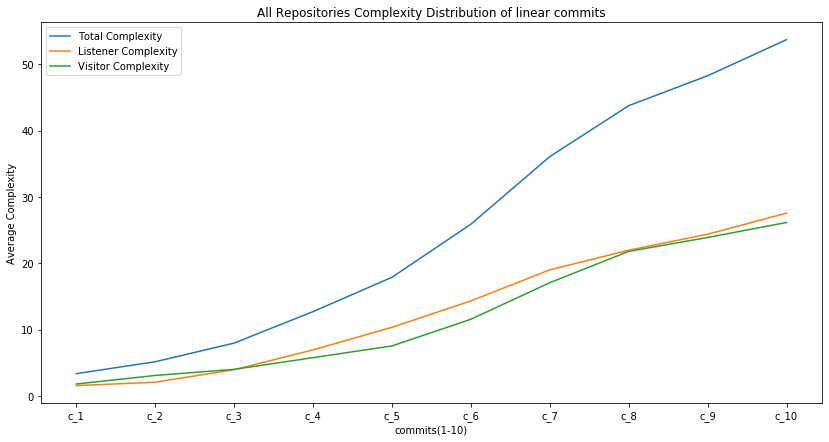

In [18]:
# _intializing line graph details 
x_values = ['c_'+str(value) for value in avg_commit_comp_df['commit_group_id']]
# _plotting line graphs with (Avg complexity vs linear commits)
show_line_graph(x_values, total_y_values, listener_y_values, visitor_y_values, "commits(1-10)", "Average Complexity", "All Repositories Complexity Distribution of linear commits")

In [19]:
# _Finding Pattern Switches from the first commit to last commit
# _assigning pattern on basis of max complexity after commit 1
repo_pattern_comp_df = repo_commit_df.loc[repo_commit_df['commit_group_id'] == 1]
repo_pattern_list_1 = get_repo_pattern_map(repo_pattern_comp_df)

In [20]:
# _assigning pattern on basis of max complexity after commit 10
repo_pattern_comp_df = repo_commit_df.loc[repo_commit_df['commit_group_id'] == 10]
repo_pattern_list_10 = get_repo_pattern_map(repo_pattern_comp_df)

In [21]:
# _transforming repository pattern information to a pandas dataframe
repo_pattern_df_1 = pd.DataFrame(repo_pattern_list_1, columns=['repo_index', 'start_antlr_pattern'])
repo_pattern_df_1.set_index('repo_index', inplace=True)
repo_pattern_df_10 = pd.DataFrame(repo_pattern_list_10, columns=['repo_index', 'end_antlr_pattern'])
repo_pattern_df_10.set_index('repo_index', inplace=True)

# _merging commit 1 and commit 10 pattern dataframes based on the repo index
repo_pattern_df = pd.merge(repo_pattern_df_1, repo_pattern_df_10, on = 'repo_index', how='outer')
repo_pattern_df

,start_antlr_pattern,end_antlr_pattern
repo_index,,
6,listener,listener
7,visitor,visitor
9,listener,listener
18,visitor,visitor
20,listener,listener
...,...,...
433,NaN,visitor
434,NaN,listener
435,NaN,visitor


In [22]:
# _initializing pattern switch count to zero
pattern_switch_cnt = 0

# _incrementing count, if there are any switch (start pattern is different from end pattern)
for repo_index, start_pattern, end_pattern in zip(repo_pattern_df.index, repo_pattern_df['start_antlr_pattern'], repo_pattern_df['end_antlr_pattern']):
    if start_pattern in ('visitor', 'listener') and start_pattern != end_pattern:
        print(f'Repository {repo_index} switched from {start_pattern} pattern to {end_pattern}')
        pattern_switch_cnt += 1
        
print(f'No.of Repositories switched antlr patterns - {pattern_switch_cnt}')

No.of Repositories switched antlr patterns - 0


In [23]:
#_ as pattern switches are very insignificant, we are analyzing the percentage of patterns after commits
# _finding listener, visitor and both (l,v) counts after commit 1, 5 and 10 respectively
listener_cnt_1, visitor_cnt_1, listener_visitor_1 = get_pattern_cnt_with_commit(1)
listener_cnt_5, visitor_cnt_5, listener_visitor_5 = get_pattern_cnt_with_commit(5)
listener_cnt_10, visitor_cnt_10, listener_visitor_10 = get_pattern_cnt_with_commit(10)

In [24]:
pie_chart_datapoints_1 = [listener_visitor_1, listener_cnt_1, visitor_cnt_1]
pie_chart_datapoints_5 = [listener_visitor_5, listener_cnt_5, visitor_cnt_5]
pie_chart_datapoints_10 = [listener_visitor_10, listener_cnt_10, visitor_cnt_10]
pie_chart_labels = ['Listener and Visitor', 'Only Listener', 'Only Visitor']

/home/praveen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  app.launch_new_instance()


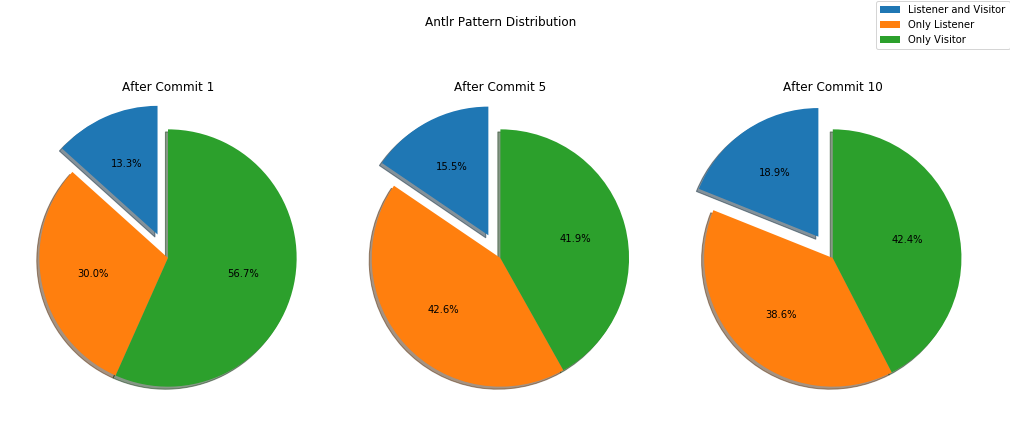

In [25]:
# _analyzing repository pattern counts (in percentages), to get the information pattern adoption over the time of all commits
show_pie_chart(pie_chart_datapoints_1, pie_chart_datapoints_5, pie_chart_datapoints_10, pie_chart_labels, [0.2, 0, 0], 'Antlr Pattern Distribution')